1. Prepare the dataset:

In [1]:
import numpy as np; import pandas as pd; import string; import statsmodels.formula.api as sm
import matplotlib.pyplot as plt; import seaborn
%matplotlib inline

df = pd.read_stata("C:/Users/tew207/Desktop/BHPS_1_18.dta")

tinit = 1992; tlast = 2009
years = range(tinit, tlast+1)

uk_cpi = {2014:127.97,2013:126.1,2012:123.0,2011:119.61,2010:114.48,2009:110.83,2008:108.48,2007:104.70,
          2006:102.3,2005:113.5,2004:111.2,2003:109.8,2002:108.3,2001:106.9,2000:105.6,1999:104.8,1998:103.4,
          1997:101.8,1996:100,1995:97.6,1994:95.1,1993:93.2,1992:90.9}

df['yrobs'] = df.groupby('pid').pid.transform('count')
    
print "There are",len(df[df.yrobs<5].pid.unique()),"households with less than 5 observations"
print "Keeping",len(df[df.yrobs>4].pid.unique()),"households with more than 5 observations"
df = df[df.yrobs>4]

for x in string.ascii_lowercase[0:18]:
    df2 = pd.read_stata("C:/Users/tew207/Desktop/PhD_Data/BHPS/Data/"+x+"_neta.dta")
    df = pd.merge(df, df2, left_on=['hid'], right_on=[x+'hid'], how='left')
    

# Total annual gross labour income
df['hhyrlg'] = 0 
# Total annual net labour income (gross - NI contributions - pension contributions + tax credits)
df['hhyrln'] = 0
# Total annual net income (net labour + investments + benefits + pensions + transfers)
df['hhyneti'] = 0
# Total annual net income, equivalized and deflated by OECD scale
df['hhnyrde2'] = 0

for (x,yr) in zip(string.ascii_lowercase[0:18], range(1992,2010)):
    df.loc[df.year==yr, 'hhyrln'] = df.loc[df.year==yr, x+'hhyrln']
    df.loc[df.year==yr, 'hhyrlg'] = df.loc[df.year==yr, x+'hhyrlg']
    df.loc[df.year==yr, 'hhyneti'] = df.loc[df.year==yr, x+'hhyneti']
    df.loc[df.year==yr, 'hhnyrde2'] = df.loc[df.year==yr, x+'hhnyrde2']

There are 3935 households with less than 5 observations
Keeping 4502 households with more than 5 observations


2. Deflate nominal variables, throw out households with too little income:

In [2]:
# Deflate nominal variables to 1996 pounds:
for yr in years:
    df.loc[df.year==yr, ['hhyrln', 'hhyrlg', 'hhyneti']] = 100*df[['hhyrln', 'hhyrlg', 'hhyneti']]/uk_cpi[yr]

# Throw out households with too little income
print "Dropping",len(df[(df.hhnyrde2<1000) | (df.hhyrlg<1000)].pid.unique()),"households with low incomes"
df = df[(df.hhnyrde2>1000) & (df.hhyrlg>1000)]

# Take logs
df['logrnetlabinc'] = np.log(df.hhyrln)
df['logrgrosslabinc'] = np.log(df.hhyrlg)
df['logrnetinc'] = np.log(df.hhyneti)
df['logrnetincdef'] = np.log(df.hhnyrde2)

Dropping 1032 households with low incomes


Calculating experience from end of education:

In [3]:
df['scend'] = df.groupby('pid').scend.transform(max)
df['feend'] = df.groupby('pid').feend.transform(max)

df['edu_end'] =  df.scend.clip(12,np.inf)
df.loc[df.feend>df.scend, 'edu_end'] = df.feend
df['expr'] = df.age - df.edu_end

df["exprsq"] = df["expr"]**2/100
df["exprcu"] = df["expr"]**3/1000

Run pooled regression:

$$ 
log(y_{i,t}) = \beta_0 + \beta_1 (expr) + \beta_2 \frac{expr^2}{100} + \beta_3 \frac{expr^3}{1000} + \varepsilon
$$

In [4]:
result = sm.ols("logrgrosslabinc ~ expr + exprsq + exprcu", data=df).fit()
# save coefficients
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        logrgrosslabinc   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     389.2
Date:                Fri, 18 Sep 2015   Prob (F-statistic):          8.28e-249
Time:                        19:15:18   Log-Likelihood:                -39016.
No. Observations:               36232   AIC:                         7.804e+04
Df Residuals:                   36228   BIC:                         7.807e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      9.6454      0.040    239.077      0.000         9.566     9.724
expr           0.0236      0.005      4.596      0.000         0.014     0.034
exprsq         0.0194      0.020      0.968      0.333        -0.020     0.059
exprcu        -0.0142      0.002     -5.949      0.000        -0.019    -0.010
==============================================================================
Omnibus:                     5414.815   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11077.677
Skew:                          -0.914   Prob(JB):                         0.00
Kurtosis:                       4.999   Cond. No.                         608.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regression results:

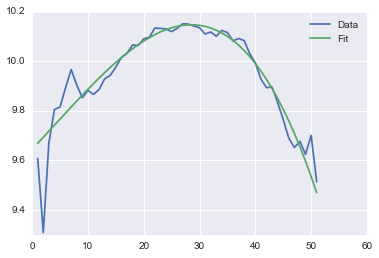

In [5]:
fig, ax = plt.subplots()
ax.plot(range(1,52), [df[df.expr==i].logrgrosslabinc.mean() for i in range(1,52)], label = "Data")
ax.plot(range(1,52), [9.6454 + 0.0236*expr + 0.0194*expr**2/100 - 0.0142*expr**3/1000 for expr in range(1,52)], label ="Fit")
ax.legend(loc=0);

In [1]:
# Results from Guvenen PSID sample 
g_t = [8.36 + 0.07*t - 0.15*t^2/100 for t in range(1,41)];

In the paper, the income process for log labour income is given as:

$$ 
y_t^i = g(t) + \alpha^i + \beta^i t + z_t^i + \varepsilon_t^i
$$

Which would imply income an income level:

$$
Y_t^i = e^{g(t)}e^{\alpha^i + \beta^i t + z_t^i + \varepsilon_t^i}
$$

Now, the basic structure of drawing an income process in Guvenen's paper is:

In [16]:
using Distributions
# Parameters:
μₐ = 2.0; μᵦ = 0.009; var_α = 0.02; cov_αβ = -0.0003; var_β = 0.00037; var_η=0.029; var_ɛ=0.047; ρ=0.82; fpu=0.65
min_β = max(-0.05, μᵦ-2.5*sqrt(var_β))

# Draw some α,β pairs
ab = MvNormal([μₐ; μᵦ], [var_α cov_αβ; cov_αβ var_β])
draw1 = rand(ab, 1000)'
draw2 = rand(ab, 1000)'
for i = 1:1000
draw1[i,2] < min_β ? draw1[i,2] = min_β + abs(draw1[i,2]-min_β)/50.0 : 0
draw2[i,2] < min_β ? draw2[i,2] = min_β + abs(draw2[i,2]-min_β)/50.0 : 0
end
α = (draw1[:,1] + draw2[:,1])/2.
α = reshape(repmat(α,1,100)', 100000)
β_u = reshape(repmat(draw1[:, 2],1,100)', 100000)
β_k = reshape(repmat(draw2[:, 2],1,100)', 100000)
β = (1-fpu)*β_k + fpu*β_u

# Draw the income distribution:
yit = zeros(100000, 40); z = similar(yit)
z[:, 1] = sqrt(var_η/(1-ρ^2))*randn(100000) # Initial condition for persistent shock

for t = 1:40, i = 1:100000 # 100,000 agents for 40 periods
    yit[i, t] = exp(α[i] + β[i]*t + z[i, t] + sqrt(var_ɛ)*randn())
    t < 40 ? z[i, t+1] = ρ*z[i, t] + sqrt(var_η)*randn() : 0
end

Given that we are already drawing $e^{\alpha^i + \beta^i t + z_t^i + \varepsilon_t^i}$, it would appear that to add the life cycle profile of earnings to it, we would have to premultiply the draw in the last loop by $e^{g(t)}$:

In [17]:
yit_lc = zeros(100000, 40); z = similar(yit)
z[:, 1] = sqrt(var_η/(1-ρ^2))*randn(100000) # Initial condition for persistent shock

for t = 1:40, i = 1:100000 # 100,000 agents for 40 periods
    yit_lc[i, t] = exp(g_t[t])*exp(α[i] + β[i]*t + z[i, t] + sqrt(var_ɛ)*randn())
    t < 40 ? z[i, t+1] = ρ*z[i, t] + sqrt(var_η)*randn() : 0
end

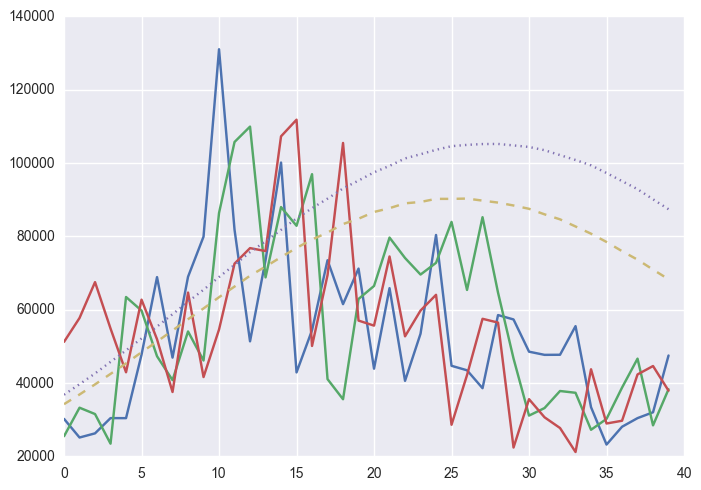

In [18]:
agt = rand(1:100000, 3)

using PyPlot, PyCall
@pyimport seaborn

fig, ax = subplots()
ax[:plot](yit_lc[agt[1],:]', label = "Path 1")
ax[:plot](yit_lc[agt[2],:]', label = "Path 2")
ax[:plot](yit_lc[agt[3],:]', label = "Path 3")
ax[:plot]([mean(yit_lc[:,t]) for t=1:40], label = "Mean Income", linestyle = ":")
ax[:plot]([median(yit_lc[:,t]) for t=1:40], label = "Median Income", linestyle = "--");

In [19]:
median(yit_lc[:,40])

68281.74763257493